# Graph Neural Network for Multi-Asset Market Modeling — Variant C 📈

This notebook implements a GNN + LSTM model for predicting the next-step direction of Asset A using multi-asset time series, incorporating **learnable attention** over a set of precomputed correlation windows.

### Features
- Candidate correlation windows: **30min, 1h, 2h, 4h**
- **NaN-safe** normalization and correlation calculation.
- **Multi-window attention** (softmax-weighted combination) for dynamic correlation weighting.
- Monitoring attention weights per epoch for **interpretability**.
- Synthetic dataset $T \approx 3000$.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Research-grade GNN-LSTM pipeline for multi-asset market modeling.
Predicts direction of price for Asset A using multi-window attention over correlations.

Structure:
1) Synthetic data generation (3k rows, 5m intervals)
2) Preprocessing, cleaning, winsorization, normalization
3) Rolling correlations with multiple windows (5 windows)
4) Dataset + DataLoader + collate_fn
5) GNN (GCN-style) + LSTM temporal aggregator + classifier
6) Train/Val/Test split 50-20-30
7) Training loop with accuracy, loss tracking
8) Monitoring attention + avg adjacency
9) Visualization for train and for test
"""

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random


In [3]:

# ============================================================
# 1. Synthetic dataset generation (3000 timesteps)
# ============================================================

T = 3000
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

price_A = np.cumsum(np.random.randn(T) * 0.01 + 1.3)
price_B = np.cumsum(np.random.randn(T) * 10 + 6e4)
price_C = np.cumsum(np.random.randn(T) * 2 + 2e3)

vol_A = np.random.lognormal(mean=7, sigma=1.0, size=T)
vol_B = np.random.lognormal(mean=10, sigma=1.5, size=T)
vol_C = np.random.lognormal(mean=8, sigma=1.2, size=T)

df = pd.DataFrame({
    "price_A": price_A, "vol_A": vol_A,
    "price_B": price_B, "vol_B": vol_B,
    "price_C": price_C, "vol_C": vol_C
})

# log returns & target
df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)
df["dir_A_next"] = (df["price_A"].shift(-1) > df["price_A"]).astype(int)

# ============================================================
# 2. Full cleaning pipeline
# ============================================================

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = df[col].clip(lower=1e-6)

def winsorize(series, q=0.995):
    low = series.quantile(1-q)
    high = series.quantile(q)
    return series.clip(lower=low, upper=high)

for col in ["vol_A", "vol_B", "vol_C"]:
    df[col] = winsorize(df[col])

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.ffill(inplace=True)
df.bfill(inplace=True)

for col in ["price_A", "price_B", "price_C"]:
    df[col] = df[col].clip(lower=1e-8)

df["lr_A"] = np.log(df["price_A"]).diff().fillna(0)
df["lr_B"] = np.log(df["price_B"]).diff().fillna(0)
df["lr_C"] = np.log(df["price_C"]).diff().fillna(0)

for col in ["lr_A", "lr_B", "lr_C"]:
    df[col] = df[col].clip(lower=-0.2, upper=0.2)

print("\nSanitized Data Summary:\n", df.describe())



Sanitized Data Summary:
            price_A         vol_A       price_B         vol_B       price_C  \
count  3000.000000   3000.000000  3.000000e+03  3.000000e+03  3.000000e+03   
mean   1951.150049   1701.298826  9.002950e+07  6.740668e+04  3.000973e+06   
std    1126.391151   1881.160802  5.196987e+07  1.358812e+05  1.732339e+06   
min       1.304967     70.428043  5.998092e+04  5.410132e+02  1.997772e+03   
25%     975.833923    560.015041  4.504503e+07  8.336019e+03  1.501461e+06   
50%    1951.389635   1071.858029  9.002934e+07  2.329542e+04  3.000952e+06   
75%    2926.118806   2065.751060  1.350144e+08  6.340632e+04  4.500459e+06   
max    3900.960025  12658.256058  1.799989e+08  1.130740e+06  6.000019e+06   

              vol_C         lr_A         lr_B         lr_C   dir_A_next  
count   3000.000000  3000.000000  3000.000000  3000.000000  3000.000000  
mean    6056.583389     0.002398     0.002399     0.002399     0.999667  
std     8760.147872     0.010671     0.010682    

In [4]:

# ============================================================
# 3. Multi-window correlations
# ============================================================

candidate_windows = [6, 12, 24, 48, 96]   # 30m, 1h, 2h, 4h, 8h
n_w = len(candidate_windows)

edges = [("A","B"), ("A","C"), ("C","B")]
n_edges = len(edges)

corr_array = np.zeros((T, n_edges, n_w), dtype=np.float32)

for wi, w in enumerate(candidate_windows):
    r_ab = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_B"])
    r_ac = df["lr_A"].rolling(w, min_periods=1).corr(df["lr_C"])
    r_cb = df["lr_C"].rolling(w, min_periods=1).corr(df["lr_B"])

    corr_array[:,0,wi] = np.nan_to_num(r_ab)
    corr_array[:,1,wi] = np.nan_to_num(r_ac)
    corr_array[:,2,wi] = np.nan_to_num(r_cb)

print("corr_array shape:", corr_array.shape)


corr_array shape: (3000, 3, 5)


In [5]:

# ============================================================
# 4. Dataset + DataLoader
# ============================================================

class MarketDataset(Dataset):
    def __init__(self, df, corr_array, window=12, normalize=True):
        self.df = df.reset_index(drop=True)
        self.T = len(df)
        self.window = window
        self.corr_array = corr_array
        self.normalize = normalize

        prices = df[["price_A","price_B","price_C"]].values
        lv = np.log1p(df[["vol_A","vol_B","vol_C"]].values)

        self.p_mean = prices.mean(0)
        self.p_std  = prices.std(0) + 1e-6
        self.v_mean = lv.mean(0)
        self.v_std  = lv.std(0) + 1e-6

    def __len__(self):
        return self.T - self.window - 1

    def __getitem__(self, idx):
        x_seq = []
        for t in range(idx, idx+self.window):
            row = self.df.loc[t]

            price = np.array([row.price_A, row.price_B, row.price_C], np.float32)
            vol   = np.log1p(np.array([row.vol_A, row.vol_B, row.vol_C], np.float32))

            if self.normalize:
                price = (price - self.p_mean)/self.p_std
                vol   = (vol   - self.v_mean)/self.v_std

            nf = np.stack([price, vol], axis=1).astype(np.float32)
            x_seq.append(torch.tensor(nf))

        target = int(self.df.loc[idx+self.window].dir_A_next)

        corr_slice = self.corr_array[idx:idx+self.window,:,:]

        return x_seq, torch.tensor(target, dtype=torch.long), torch.tensor(corr_slice, dtype=torch.float32)

def collate_fn(batch):
    return batch[0]


In [6]:

# ============================================================
# 5. Train/Val/Test split 50–20–30
# ============================================================

total_len = len(df)
train_end = int(total_len * 0.50)
val_end   = int(total_len * 0.70)

df_train = df.iloc[:train_end].reset_index(drop=True)
df_val   = df.iloc[train_end:val_end].reset_index(drop=True)
df_test  = df.iloc[val_end:].reset_index(drop=True)

corr_train = corr_array[:train_end]
corr_val   = corr_array[train_end:val_end]
corr_test  = corr_array[val_end:]

dataset_train = MarketDataset(df_train, corr_train)
dataset_val   = MarketDataset(df_val,   corr_val)
dataset_test  = MarketDataset(df_test,  corr_test)

loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
loader_val   = DataLoader(dataset_val,   batch_size=1, shuffle=False, collate_fn=collate_fn)
loader_test  = DataLoader(dataset_test,  batch_size=1, shuffle=False, collate_fn=collate_fn)

print("\nDataset sizes:")
print("Train:", len(dataset_train))
print("Val:  ", len(dataset_val))
print("Test: ", len(dataset_test))



Dataset sizes:
Train: 1487
Val:   587
Test:  887


In [7]:

# ============================================================
# 6. GNN + LSTM model
# ============================================================

class GNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=32, lstm_hidden=32, n_edges=3, n_windows=5):
        super().__init__()
        self.fc_node = nn.Linear(2, hidden_dim)
        self.attn = nn.Parameter(torch.randn(n_edges, n_windows))
        self.lstm = nn.LSTM(hidden_dim, lstm_hidden, batch_first=True)
        self.fc_out = nn.Linear(lstm_hidden, 2)

    def forward(self, x_seq, corr_slice):
        L = len(x_seq)
        x = torch.stack([self.fc_node(e) for e in x_seq], dim=0)  # (L,3,h)

        attn_w = F.softmax(self.attn, dim=-1)  # (3,5)
        corr_w = torch.einsum("l e w, e w -> l e", corr_slice, attn_w)

        h = x.clone()

        # message passing (GCN-style)
        h[:,0,:] += corr_w[:,0:1]*x[:,1,:] + corr_w[:,1:2]*x[:,2,:]
        h[:,1,:] += corr_w[:,0:1]*x[:,0,:] + corr_w[:,2:3]*x[:,2,:]
        h[:,2,:] += corr_w[:,1:2]*x[:,0,:] + corr_w[:,2:3]*x[:,1,:]

        # only node A -> LSTM
        a_seq = h[:,0,:].unsqueeze(0)  # (1,L,hid)
        out,_ = self.lstm(a_seq)
        last = out[:, -1, :]  # final hidden state
        logits = self.fc_out(last)
        return logits, attn_w, corr_w

model = GNN_LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [8]:

# ============================================================
# 7. Training loop (Train + Val)
# ============================================================

n_epochs = 15
train_loss_hist = []
train_acc_hist = []
val_acc_hist = []
attn_history = []
avg_adj_hist = []

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_seq, target, corr_slice in loader:
            logits, _, _ = model(x_seq, corr_slice)
            pred = logits.argmax(1)
            correct += (pred == target).sum().item()
            total += 1
    return correct/total if total>0 else 0

for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    attn_epoch = []
    adj_epoch = []

    for x_seq, target, corr_slice in loader_train:
        optimizer.zero_grad()
        logits, attn_w, corr_w = model(x_seq, corr_slice)
        loss = criterion(logits, target.unsqueeze(0))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == target).sum().item()
        total += 1

        attn_epoch.append(attn_w.detach().numpy())
        adj_epoch.append(corr_w.mean(0).detach().numpy())

    train_loss_hist.append(total_loss/total)
    train_acc_hist.append(correct/total)
    val_acc = evaluate(loader_val)
    val_acc_hist.append(val_acc)

    attn_history.append(np.mean(attn_epoch, axis=0))
    avg_adj_hist.append(np.mean(adj_epoch, axis=0))

    best_window = candidate_windows[np.argmax(attn_history[-1].mean(0))]

    print(f"Epoch {epoch+1}/{n_epochs} | "
          f"TrainLoss={train_loss_hist[-1]:.4f} | "
          f"TrainAcc={train_acc_hist[-1]:.4f} | "
          f"ValAcc={val_acc:.4f} | "
          f"BestWindow={best_window}")

attn_history = np.stack(attn_history)
avg_adj_hist = np.stack(avg_adj_hist)


Epoch 1/15 | TrainLoss=0.0088 | TrainAcc=0.9993 | ValAcc=1.0000 | BestWindow=96
Epoch 2/15 | TrainLoss=0.0001 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 3/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 4/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 5/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 6/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 7/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 8/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 9/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 10/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 11/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 12/15 | TrainLoss=0.0000 | TrainAcc=1.0000 | ValAcc=1.0000 | BestWindow=96
Epoch 13/15 | TrainLoss=0.0000 | Trai

In [9]:

# ============================================================
# 8. Test evaluation
# ============================================================

test_acc = evaluate(loader_test)
print("\n==========================")
print("FINAL TEST ACCURACY:", test_acc)
print("==========================\n")



FINAL TEST ACCURACY: 1.0



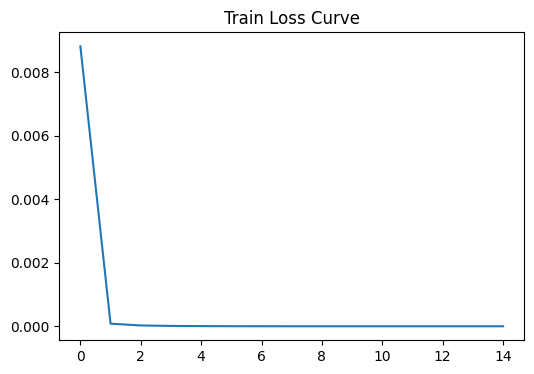

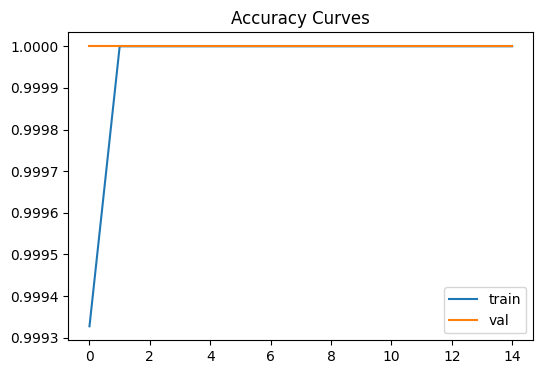

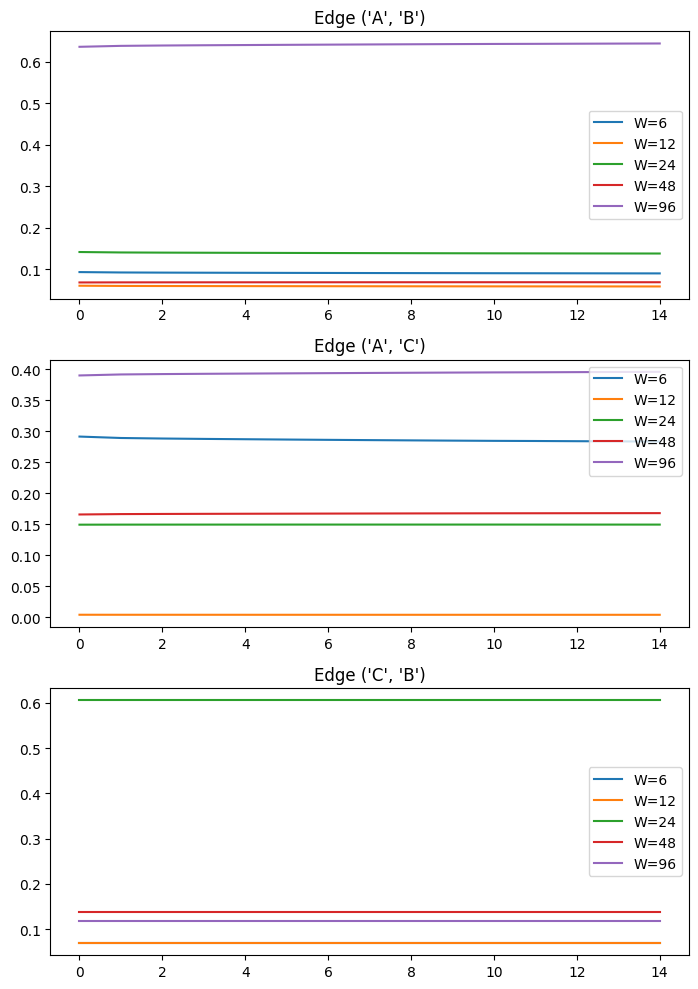

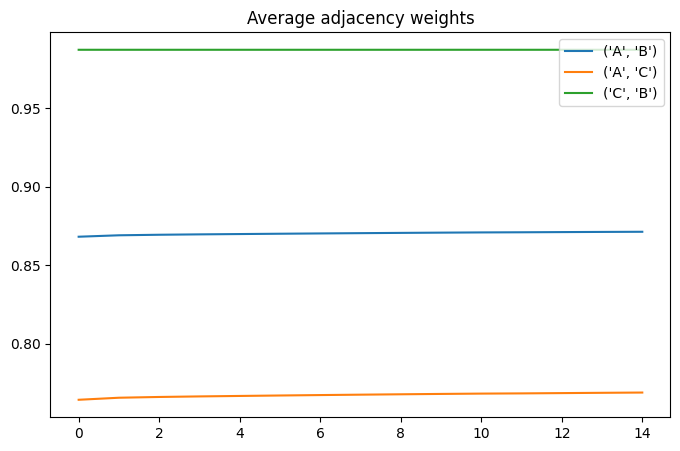

Done.


In [10]:

# ============================================================
# 9. Visualization
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_loss_hist)
plt.title("Train Loss Curve")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="train")
plt.plot(val_acc_hist, label="val")
plt.title("Accuracy Curves")
plt.legend()
plt.show()

# Attention evolution
fig, axes = plt.subplots(n_edges,1, figsize=(7,10))
for e in range(n_edges):
    for w in range(n_w):
        axes[e].plot(attn_history[:,e,w], label=f"W={candidate_windows[w]}")
    axes[e].set_title(f"Edge {edges[e]}")
    axes[e].legend()
plt.tight_layout()
plt.show()

# Average adjacency
plt.figure(figsize=(8,5))
for e in range(n_edges):
    plt.plot(avg_adj_hist[:,e], label=str(edges[e]))
plt.legend()
plt.title("Average adjacency weights")
plt.show()

print("Done.")
